In [1]:
import pandas as pd
from utils import *
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, ConfusionMatrixDisplay
from sklearn.model_selection import RandomizedSearchCV, train_test_split

import numpy as np
# Tree Visualisation
from sklearn.tree import export_graphviz
from IPython.display import Image

from xgboost import XGBClassifier
import xgboost as xgb


In [2]:
df_matches_sm = load_clean_data()

/Users/katybarone/Documents/projects/tennis/utils.py:7: DtypeWarning: Columns (8,16) have mixed types. Specify dtype option on import or set low_memory=False.
  df_matches = pd.read_csv("atp_matches_all.csv")


In [3]:
df_matches_sm.head()

,match_id,tourney_date,surface,winner_id,loser_id,w_ace,w_df,w_svpt,w_1stIn,w_1stWon,...,l_2ndWon_opp,l_SvGms_opp,l_bpSaved_opp,l_bpFaced_opp,l_minutes_opp,l_losses_opp,l_wins_opp,l_num_matches_opp,l_win_pct_opp,lower_won
0,28,2018-12-31,Hard,105138,104925,3.359375,2.320312,78.320312,49.515625,35.234375,...,13.8,13.4,2.0,5.2,139.4,1.0,4.0,5.0,0.8,1
1,34,2018-12-31,Hard,104925,105916,4.533333,2.542857,75.380952,48.152381,35.800000,...,17.0,17.0,7.0,13.0,179.0,1.0,0.0,1.0,0.0,0
2,42,2018-12-31,Hard,104925,106000,4.533333,2.542857,75.380952,48.152381,35.800000,...,7.0,5.0,5.0,8.0,53.0,1.0,0.0,1.0,0.0,0
3,49,2018-12-31,Hard,105138,126610,3.359375,2.320312,78.320312,49.515625,35.234375,...,14.0,11.0,0.0,0.0,105.0,0.0,1.0,1.0,1.0,1
4,51,2018-12-31,Hard,105583,105173,3.877193,2.000000,81.175439,54.666667,37.017544,...,20.0,14.0,8.0,15.0,124.0,1.0,0.0,1.0,0.0,1


In [5]:
df_matches_sm.to_csv("training_data_pre_encoding.csv")

In [4]:
df_matches_sm.to_csv("dataset_new.csv", index=False)

In [4]:
df_matches_sm = pd.read_csv("dataset.csv")

In [5]:
from sklearn.preprocessing import LabelEncoder
ioc_encoder = LabelEncoder()
df_matches_sm['w_ioc_encoded'] = ioc_encoder.fit_transform(df_matches_sm['w_ioc'])
df_matches_sm['l_ioc_encoded'] = ioc_encoder.fit_transform(df_matches_sm['l_ioc'])
surface_encoder = LabelEncoder()
df_matches_sm['surface_encoded'] = surface_encoder.fit_transform(df_matches_sm['surface'])

mapping_surface = dict(zip(surface_encoder.classes_, surface_encoder.transform(surface_encoder.classes_)))

df_matches_sm.drop(columns=['w_ioc', 'l_ioc', 'surface'], axis=1, inplace=True)

df_matches_sm['w_id'] = df_matches_sm['winner_id']
df_matches_sm['l_id'] = df_matches_sm['loser_id']
print(mapping_surface)

{'Clay': 0, 'Grass': 1, 'Hard': 2}


In [6]:
def shuffle_and_rename(df):
    # Create a boolean mask that randomly decides whether to swap winners and losers
    mask = np.random.rand(len(df)) > 0.5

    # Initialize empty DataFrames for player1 and player2
    player1_df = pd.DataFrame()
    player2_df = pd.DataFrame()

    # Assign columns based on the mask
    # If mask is True, winner becomes player1, else loser becomes player1
    player1_df = df[mask].rename(columns=lambda x: x.replace('w_', 'player1_').replace('l_', 'player2_'))
    player2_df = df[~mask].rename(columns=lambda x: x.replace('w_', 'player2_').replace('l_', 'player1_'))

    # Concatenate the two DataFrames back together
    shuffled_df = pd.concat([player1_df, player2_df])

    return shuffled_df

# Apply the function
df_rand = shuffle_and_rename(df_matches_sm)

# Shuffle the final DataFrame rows if necessary
#df_rand = df_rand.sample(frac=1).reset_index(drop=True)
df_rand['output'] = df_rand.apply(lambda x: 1 if x['winner_id'] == x['player1_id'] else 0, axis=1)
df_rand.sort_values('match_id', inplace=True)
df_rand.drop(columns=['tourney_date','date_x','date_y'], inplace=True)
# View the result
df_rand.drop_duplicates(inplace=True)
df_rand


,match_id,winner_id,loser_id,player1_ace,player1_df,player1_svpt,player1_1stIn,player1_1stWon,player1_2ndWon,player1_SvGms,...,player2_wins_opp,player2_num_matches_opp,player2_win_pct_opp,lower_won,player1_ioc_encoded,player2_ioc_encoded,surface_encoded,player1_id,player2_id,output
0,1,200282,111442,4.421053,2.157895,77.473684,47.631579,33.000000,16.736842,12.157895,...,0.0,1.0,0.000000,0,1,1,2,200282,111442,1
1,2,200282,111442,6.428571,2.166667,83.833333,52.404762,37.023810,14.952381,13.047619,...,3.0,4.0,0.750000,0,1,1,2,111442,200282,0
2,3,200282,111442,6.100000,2.300000,73.600000,47.800000,33.700000,12.400000,11.200000,...,2.0,3.0,0.666667,0,1,1,1,111442,200282,0
3,4,105777,111442,6.661290,1.854839,79.967742,48.951613,34.983871,15.241935,12.451613,...,1.0,2.0,0.500000,0,1,6,2,111442,105777,0
4,5,105777,111442,6.450000,2.050000,83.675000,52.650000,37.175000,14.800000,13.025000,...,0.0,1.0,0.000000,0,1,6,2,111442,105777,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2546,4838,208363,209260,1.000000,1.375000,65.125000,46.375000,28.250000,9.000000,10.000000,...,1.0,1.0,1.000000,0,0,21,0,208363,209260,1
2547,4843,208029,111576,2.527778,3.527778,80.611111,49.694444,34.055556,16.472222,12.472222,...,0.0,1.0,0.000000,0,12,20,0,208029,111576,1
2548,4851,200221,210150,9.750000,2.750000,82.875000,53.250000,39.375000,14.625000,13.125000,...,0.0,1.0,0.000000,0,11,13,2,210150,200221,0
2549,4852,105870,210150,3.250000,1.687500,73.479167,47.875000,32.083333,13.187500,11.479167,...,1.0,1.0,1.000000,1,17,11,0,105870,210150,1


In [7]:
# Split the data into features (X) and target (y)
X = df_rand.drop(['lower_won', 'match_id', 'winner_id', 'loser_id', 'player1_id', 
                  'player2_id', 'output', 'opponent_x', 'opponent_y'], axis=1)

#X = df_matches_sm.drop(['lower_won','l_rank','w_rank'], axis=1)
#y = df_matches_sm['lower_won']
y = df_rand['output']

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

In [8]:
# Baselining accuracy by saying that the higher ranked player should win every time
y_base = X_test.apply(lambda x: 1 if x['player1_rank'] < x['player2_rank'] else 0, axis=1)
accuracy_score(y_test, y_base)

0.6360078277886497

In [9]:
dtrain = xgb.DMatrix(X_train, label=y_train)
#dval = xgb.DMatrix(X_val, label=y_val)
dtest = xgb.DMatrix(X_test, label=y_test)

In [10]:
params = {
    # Parameters that we are going to tune.
    'max_depth':6,
    'min_child_weight': 1,
    'eta':.3,
    'subsample': 1,
    'colsample_bytree': 1,
    # Other parameters
    'objective':'binary:logistic',
}
params['eval_metric'] = "mae"
num_boost_round = 999

model = xgb.train(
    params,
    dtrain,
    num_boost_round=num_boost_round,
    evals=[(dtest, "Test")],
    early_stopping_rounds=10
)

[0]	Test-mae:0.46846
[1]	Test-mae:0.44391
[2]	Test-mae:0.42135
[3]	Test-mae:0.40110
[4]	Test-mae:0.39044
[5]	Test-mae:0.37966
[6]	Test-mae:0.36884
[7]	Test-mae:0.35552
[8]	Test-mae:0.34945
[9]	Test-mae:0.34740
[10]	Test-mae:0.33742
[11]	Test-mae:0.33385
[12]	Test-mae:0.32538
[13]	Test-mae:0.32686
[14]	Test-mae:0.32567
[15]	Test-mae:0.32402
[16]	Test-mae:0.32459
[17]	Test-mae:0.32437
[18]	Test-mae:0.32001
[19]	Test-mae:0.30835
[20]	Test-mae:0.30536
[21]	Test-mae:0.29752
[22]	Test-mae:0.29962
[23]	Test-mae:0.29715
[24]	Test-mae:0.29808
[25]	Test-mae:0.29830
[26]	Test-mae:0.29712
[27]	Test-mae:0.29595
[28]	Test-mae:0.29630
[29]	Test-mae:0.29487
[30]	Test-mae:0.29188
[31]	Test-mae:0.28423
[32]	Test-mae:0.28419
[33]	Test-mae:0.28345
[34]	Test-mae:0.28448
[35]	Test-mae:0.28549
[36]	Test-mae:0.28392
[37]	Test-mae:0.28358
[38]	Test-mae:0.28276
[39]	Test-mae:0.27953
[40]	Test-mae:0.27997
[41]	Test-mae:0.28018
[42]	Test-mae:0.28053
[43]	Test-mae:0.28094
[44]	Test-mae:0.28203
[45]	Test-mae:0.2821

In [11]:
cv_results = xgb.cv(
    params,
    dtrain,
    num_boost_round=num_boost_round,
    seed=42,
    nfold=5,
    metrics={'mae'},
    early_stopping_rounds=10
)
cv_results

,train-mae-mean,train-mae-std,test-mae-mean,test-mae-std
0,0.452996,0.001582,0.466195,0.004122
1,0.418942,0.001454,0.438848,0.006616
2,0.389714,0.004722,0.418168,0.010621
3,0.364394,0.005560,0.396543,0.008708
4,0.340625,0.005302,0.377305,0.007654
...,...,...,...,...
119,0.015520,0.000705,0.258484,0.010844
120,0.015305,0.000684,0.258413,0.010743
121,0.015131,0.000649,0.258580,0.010786
122,0.014978,0.000615,0.258447,0.010853


In [12]:
cv_results['test-mae-mean'].min()

0.25822677382235254

In [13]:
gridsearch_params = [
    (max_depth, min_child_weight)
    for max_depth in range(7,10)
    for min_child_weight in range(3,6)
]

# Define initial best params and MAE
min_mae = float("Inf")
best_params = None
for max_depth, min_child_weight in gridsearch_params:
    print("CV with max_depth={}, min_child_weight={}".format(
                             max_depth,
                             min_child_weight))
    # Update our parameters
    params['max_depth'] = max_depth
    params['min_child_weight'] = min_child_weight
    # Run CV
    cv_results = xgb.cv(
        params,
        dtrain,
        num_boost_round=num_boost_round,
        seed=42,
        nfold=5,
        metrics={'mae'},
        early_stopping_rounds=10
    )
    # Update best MAE
    mean_mae = cv_results['test-mae-mean'].min()
    boost_rounds = cv_results['test-mae-mean'].argmin()
    print("\tMAE {} for {} rounds".format(mean_mae, boost_rounds))
    if mean_mae < min_mae:
        min_mae = mean_mae
        best_params = (max_depth,min_child_weight)
print("Best params: {}, {}, MAE: {}".format(best_params[0], best_params[1], min_mae))

CV with max_depth=7, min_child_weight=3
	MAE 0.2778671631234009 for 78 rounds
CV with max_depth=7, min_child_weight=4
	MAE 0.2727991903564401 for 147 rounds
CV with max_depth=7, min_child_weight=5
	MAE 0.2916997495663179 for 67 rounds
CV with max_depth=8, min_child_weight=3
	MAE 0.271907824968573 for 150 rounds
CV with max_depth=8, min_child_weight=4
	MAE 0.281687156707659 for 52 rounds
CV with max_depth=8, min_child_weight=5
	MAE 0.28787412012143426 for 139 rounds
CV with max_depth=9, min_child_weight=3
	MAE 0.2721965570540644 for 122 rounds
CV with max_depth=9, min_child_weight=4
	MAE 0.27796073905651697 for 86 rounds
CV with max_depth=9, min_child_weight=5
	MAE 0.2869176486481521 for 145 rounds
Best params: 8, 3, MAE: 0.271907824968573


In [14]:
params['max_depth'] = 8
params['min_child_weight'] = 3

In [15]:
gridsearch_params = [
    (subsample, colsample)
    for subsample in [i/10. for i in range(7,11)]
    for colsample in [i/10. for i in range(7,11)]
]
# Define initial best params and MAE
min_mae = float("Inf")
best_params = None

# We start by the largest values and go down to the smallest
for subsample, colsample in reversed(gridsearch_params):
    print("CV with subsample={}, colsample={}".format(
                             subsample,
                             colsample))
    # We update our parameters
    params['subsample'] = subsample
    params['colsample_bytree'] = colsample
    # Run CV
    cv_results = xgb.cv(
        params,
        dtrain,
        num_boost_round=num_boost_round,
        seed=42,
        nfold=5,
        metrics={'mae'},
        early_stopping_rounds=10
    )
    # Update best score
    mean_mae = cv_results['test-mae-mean'].min()
    boost_rounds = cv_results['test-mae-mean'].argmin()
    print("\tMAE {} for {} rounds".format(mean_mae, boost_rounds))
    if mean_mae < min_mae:
        min_mae = mean_mae
        best_params = (subsample,colsample)
print("Best params: {}, {}, MAE: {}".format(best_params[0], best_params[1], min_mae))

CV with subsample=1.0, colsample=1.0
	MAE 0.271907824968573 for 150 rounds
CV with subsample=1.0, colsample=0.9
	MAE 0.2767695481262932 for 60 rounds
CV with subsample=1.0, colsample=0.8
	MAE 0.2754972903123506 for 172 rounds
CV with subsample=1.0, colsample=0.7
	MAE 0.27617807055478394 for 164 rounds
CV with subsample=0.9, colsample=1.0
	MAE 0.28496226794893886 for 99 rounds
CV with subsample=0.9, colsample=0.9
	MAE 0.2875988470901468 for 82 rounds
CV with subsample=0.9, colsample=0.8
	MAE 0.2950510069707354 for 66 rounds
CV with subsample=0.9, colsample=0.7
	MAE 0.2872529579217442 for 257 rounds
CV with subsample=0.8, colsample=1.0
	MAE 0.29240307735376786 for 109 rounds
CV with subsample=0.8, colsample=0.9
	MAE 0.29714636055401106 for 73 rounds
CV with subsample=0.8, colsample=0.8
	MAE 0.29673365638831023 for 68 rounds
CV with subsample=0.8, colsample=0.7
	MAE 0.3065109413517776 for 79 rounds
CV with subsample=0.7, colsample=1.0
	MAE 0.3113653796286706 for 43 rounds
CV with subsampl

In [16]:
params['subsample'] = 1
params['colsample_bytree'] = 1

In [17]:
%time
# This can take some time…
min_mae = float("Inf")
best_params = None
for eta in [.8, .65, .3, .2, .1, .05]:
    print("CV with eta={}".format(eta))
    # We update our parameters
    params['eta'] = eta
    # Run and time CV
    %time 
    cv_results = xgb.cv(params,
            dtrain,
            num_boost_round=num_boost_round,
            seed=42,
            nfold=5,
            metrics=['mae'],
            early_stopping_rounds=10)
    # Update best score
    mean_mae = cv_results['test-mae-mean'].min()
    boost_rounds = cv_results['test-mae-mean'].argmin()
    print("\tMAE {} for {} rounds\n".format(mean_mae, boost_rounds))
    if mean_mae < min_mae:
        min_mae = mean_mae
        best_params = eta
print("Best params: {}, MAE: {}".format(best_params, min_mae))

CPU times: user 5 µs, sys: 2 µs, total: 7 µs
Wall time: 11.9 µs
CV with eta=0.8
CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 7.15 µs
	MAE 0.28052570767315366 for 62 rounds

CV with eta=0.65
CPU times: user 20 µs, sys: 5 µs, total: 25 µs
Wall time: 13.1 µs
	MAE 0.2873102836112059 for 33 rounds

CV with eta=0.3
CPU times: user 18 µs, sys: 4 µs, total: 22 µs
Wall time: 12.2 µs
	MAE 0.271907824968573 for 150 rounds

CV with eta=0.2
CPU times: user 17 µs, sys: 2 µs, total: 19 µs
Wall time: 10 µs
	MAE 0.26776459354642057 for 161 rounds

CV with eta=0.1
CPU times: user 19 µs, sys: 6 µs, total: 25 µs
Wall time: 11.2 µs
	MAE 0.2680109937882448 for 305 rounds

CV with eta=0.05
CPU times: user 18 µs, sys: 1e+03 ns, total: 19 µs
Wall time: 10 µs
	MAE 0.26955722955988 for 579 rounds

Best params: 0.2, MAE: 0.26776459354642057


In [18]:
params['eta'] = .2

In [19]:
model = xgb.train(
    params,
    dtrain,
    num_boost_round=num_boost_round,
    evals=[(dtest, "Test")],
    early_stopping_rounds=11
)

[0]	Test-mae:0.47961
[1]	Test-mae:0.45849
[2]	Test-mae:0.44093
[3]	Test-mae:0.42079
[4]	Test-mae:0.40587
[5]	Test-mae:0.38962
[6]	Test-mae:0.37724
[7]	Test-mae:0.36586
[8]	Test-mae:0.35826
[9]	Test-mae:0.34967
[10]	Test-mae:0.34641
[11]	Test-mae:0.34279
[12]	Test-mae:0.34013
[13]	Test-mae:0.33528
[14]	Test-mae:0.33494
[15]	Test-mae:0.33171
[16]	Test-mae:0.32434
[17]	Test-mae:0.31702
[18]	Test-mae:0.31774
[19]	Test-mae:0.31262
[20]	Test-mae:0.31080
[21]	Test-mae:0.30703
[22]	Test-mae:0.30867
[23]	Test-mae:0.30886
[24]	Test-mae:0.30860
[25]	Test-mae:0.30546
[26]	Test-mae:0.30531
[27]	Test-mae:0.30520
[28]	Test-mae:0.30572
[29]	Test-mae:0.30524
[30]	Test-mae:0.30451
[31]	Test-mae:0.30324
[32]	Test-mae:0.30331
[33]	Test-mae:0.30000
[34]	Test-mae:0.30067
[35]	Test-mae:0.29925
[36]	Test-mae:0.29841
[37]	Test-mae:0.29823
[38]	Test-mae:0.29614
[39]	Test-mae:0.29577
[40]	Test-mae:0.29580
[41]	Test-mae:0.29463
[42]	Test-mae:0.29380
[43]	Test-mae:0.29356
[44]	Test-mae:0.29177
[45]	Test-mae:0.2919

In [20]:
print("Best MAE: {:.3f} in {} rounds".format(model.best_score, model.best_iteration+1))

Best MAE: 0.275 in 122 rounds


In [22]:
num_boost_round = model.best_iteration + 3
best_model = xgb.train(
    params,
    dtrain,
    num_boost_round=num_boost_round,
    evals=[(dtest, "Test")])

[0]	Test-mae:0.47961
[1]	Test-mae:0.45849
[2]	Test-mae:0.44093
[3]	Test-mae:0.42079
[4]	Test-mae:0.40587
[5]	Test-mae:0.38962
[6]	Test-mae:0.37724
[7]	Test-mae:0.36586
[8]	Test-mae:0.35826
[9]	Test-mae:0.34967
[10]	Test-mae:0.34641
[11]	Test-mae:0.34279
[12]	Test-mae:0.34013
[13]	Test-mae:0.33528
[14]	Test-mae:0.33494
[15]	Test-mae:0.33171
[16]	Test-mae:0.32434
[17]	Test-mae:0.31702
[18]	Test-mae:0.31774
[19]	Test-mae:0.31262
[20]	Test-mae:0.31080
[21]	Test-mae:0.30703
[22]	Test-mae:0.30867
[23]	Test-mae:0.30886
[24]	Test-mae:0.30860
[25]	Test-mae:0.30546
[26]	Test-mae:0.30531
[27]	Test-mae:0.30520
[28]	Test-mae:0.30572
[29]	Test-mae:0.30524
[30]	Test-mae:0.30451
[31]	Test-mae:0.30324
[32]	Test-mae:0.30331
[33]	Test-mae:0.30000
[34]	Test-mae:0.30067
[35]	Test-mae:0.29925
[36]	Test-mae:0.29841
[37]	Test-mae:0.29823
[38]	Test-mae:0.29614
[39]	Test-mae:0.29577
[40]	Test-mae:0.29580
[41]	Test-mae:0.29463
[42]	Test-mae:0.29380
[43]	Test-mae:0.29356
[44]	Test-mae:0.29177
[45]	Test-mae:0.2919

In [26]:
preds_ht = best_model.predict(dtest)
preds_ht  = [1 if x > 0.55 else 0 for x in preds_ht]
accuracy_score(preds_ht, y_test)

0.7710371819960861

In [27]:
best_model.save_model("best_xgboost.json")

Accuracy: 0.6927592954990215


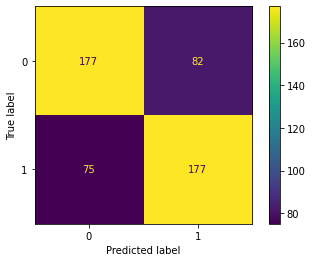

In [66]:
bst = XGBClassifier(n_estimators=4, max_depth=9, learning_rate=1, objective='binary:logistic')
# fit model
bst.fit(X_train, y_train)
# make predictions
preds = bst.predict(X_test)

accuracy = accuracy_score(y_test, preds)
print("Accuracy:", accuracy)

cm = confusion_matrix(y_test, preds)

ConfusionMatrixDisplay(confusion_matrix=cm).plot()

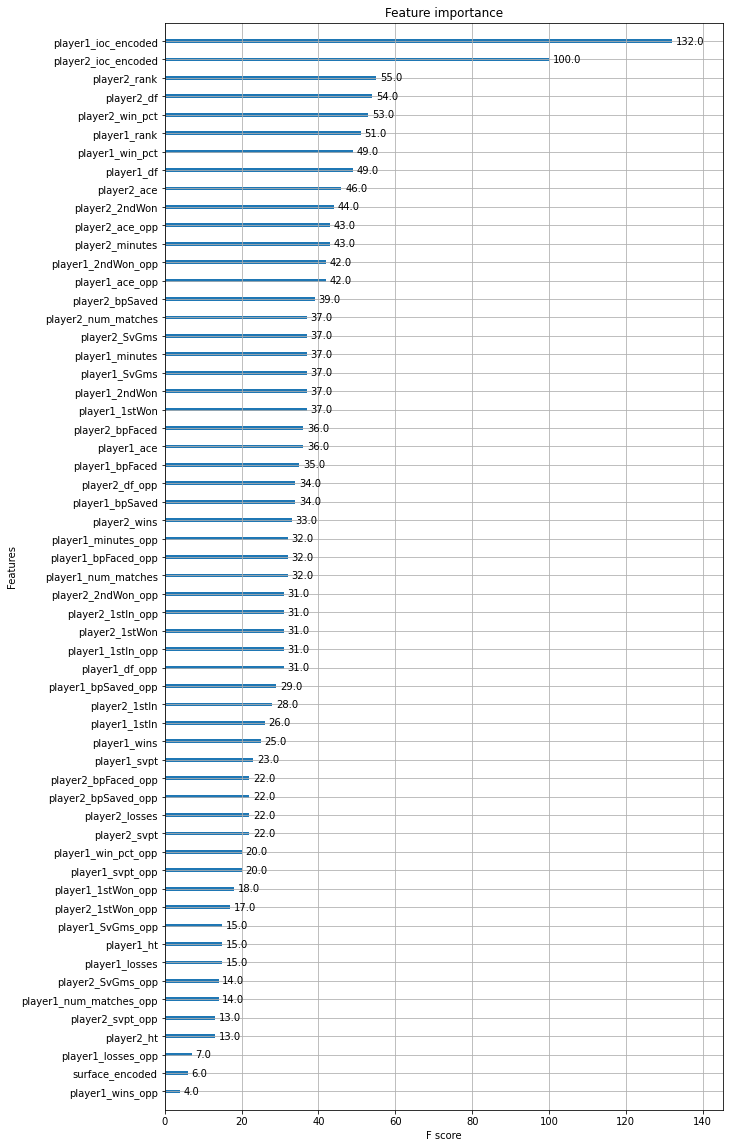

In [67]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(10, 20))
xgb.plot_importance(best_model, ax=ax)
plt.show()

In [69]:
accuracy = accuracy_score(y_test, preds_ht)
precision = precision_score(y_test, preds_ht)
recall = recall_score(y_test, preds_ht)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)

Accuracy: 0.7632093933463796
Precision: 0.7471698113207547
Recall: 0.7857142857142857
